In [1]:
%load_ext cython
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# What is Cython?

Cython is a distinct programming language, with its own syntax and semantics, which was developed with the aim of optimising Python code and making it easy to interface between Python and existing C code.

Python is very legible and easy to write, but very slow to execute. C, on the other hand, is relatively difficult to write, has many pitfalls, but is very fast to execute. Cython bridges the gap between Python and C, attempting to give the best of both worlds.

To do this, it adds many new features to Python. Cython is (almost) a superset of Python, meaning that almost all Python code is also valid Cython. However, the converse is not true; Cython's additional syntax does not work in Python code.

Cython code compiles to C code (sometimes known as a *transpiler*). This C code can then be compiled into a valid Python binary module. In practice, these steps are usually handled for you.

Cython has its own [documentation](https://cython.readthedocs.io/en/stable/), which is relatively complete, but not always easy to follow. The purpose of this crash course is to get you up to speed as quickly as possible with some of the key features and techniques.

Knowledge of Python is assumed, knowledge of C is not; however, we do not have time here to go into the specific details of Python-C interoperability, the C abstract machine, or all relevant features. In particular, we will not be covering:

 - Compound types (`enum`, `struct`)
 - Pointers (except where needed)
 - Memory model, dynamic memory
 - Working with existing C code
 
 We also won't be covering (m)any details of compilation, linking, packaging, etc.

# What does it add?

A list of features is coming, but the first thing to realise is what it allows us to *remove*.

When a Python script executes, its source code is compiled into Python bytecode, which is then executed on a stack-based *virtual machine*. The virtual machine itself is a program executed on the real CPU, introducing a level of indirection. Due to this indirection, along with the semantics of the Python language, very few automatic optimisations are possible, and each line of Python code is essentially executed "literally".

However, it is worse than this; Python's runtime and object models (particularly reference counting, exception handling, and dynamic typing) mean that one simple Python operation, such as accessing the member of a class instance, can translate into dozens of (sometimes arbitrary) function calls and many (incoherent) memory accesses.

Now, this may all seem like a lot of word-salad. To build some intuition, let's see this in action with a very simple example: dividing a number by 7.

## Division Example

The following code blocks use the `%%cython` magic command in order to compile both the Python and Cython code to C. The `--annotate` flag tells Cython that, rather than executing the code, it should generate a report showing us the Cython code it compiled and the C code which resulted on a line by line basis.

### Python

In [41]:
%%cython --annotate
def python_division(x):
    return 7 / x

If you click on line 2, you will see that just the division alone requires...

 - Updating global reference counts (`XDECREF` and `GOTREF`)
 - Error checking (`__PYX_ERR` checks to see if `__Pyx_PyNumber_Divide` has raised e.g. a `ZeroDivisionError` or `TypeError` exception)
 - (Implicit): type checking on `x` happens within `__Pyx_PyNumber_Divide`
 
 If you click on line 1, you will see even more - the amount of gumpf that Cython has to generate to perform a kosher Python function call (I count at least 2 separate C functions in here...).
 
 Compare that to the following...

### Cython

In [42]:
%%cython --annotate
cimport cython

@cython.cdivision(True)  # Turn off zero-division check
cdef double cython_division(double x):
    return x / 7

From lines 4 and 5, expanded, we see that there is still *some* boilerplate, but this almost resembles the code you would write in pure C (Note that line 5 has been "snipped" from within the expansion of line 4, where the `/* ... */` appears).

Because the Cython code specifies C semantics for these things, it is able to 

### Performance

The proof of the optimisation is in the measuring - how much faster is this, really?

We'll compare three things:

 - Numpy division
 - Cython-compiled Python version
 - Cythonised version
 
But we have to be careful here. If we just call `cython_division` 100 times from Python... well, for one, we can't. It's defined as `cdef`. This makes it accessible only from other Cython code. But even if we could (for example, defining it as `cpdef`), we would lose a large amount of the speedup by calling it from Python.

To get around this, when profiling Cython code, it is always best to write your loop in Cython, and then only call the loop function from Python. To be fair, we'll also call the Python versions from Cython.

In [43]:
def numpy_division(x):
    return 7 / x

In [44]:
%%cython --compile-args=-O3
cimport cython
import numpy as np

def python_division_fn(x):
    return 7 / x

@cython.cdivision(True)
cdef double cython_division_fn(double x):
    return 7 / x

def python_division(double[::1] x):
    cdef size_t i
    for i in range(len(x)):
        python_division_fn(x[i])

@cython.boundscheck(False)
@cython.initializedcheck(False)
@cython.wraparound(False)
cpdef double[::1] cython_division(double[::1] x):
    cdef size_t i
    # If we don't return the results, the loop will be
    # entirely optimised away by the c compiler!
    cdef double[::1] result = np.empty_like(x)
    for i in range(len(x)):
        result[i] = cython_division_fn(x[i])
    return result

In [45]:
test_data = np.random.uniform(0, 1, size=1_000_000)

In [46]:
python_speed = %timeit -o python_division(test_data)

23.6 ms ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
cython_speed = %timeit -o cython_division(test_data)

492 µs ± 877 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [48]:
numpy_speed = %timeit -o numpy_division(test_data)

249 µs ± 609 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


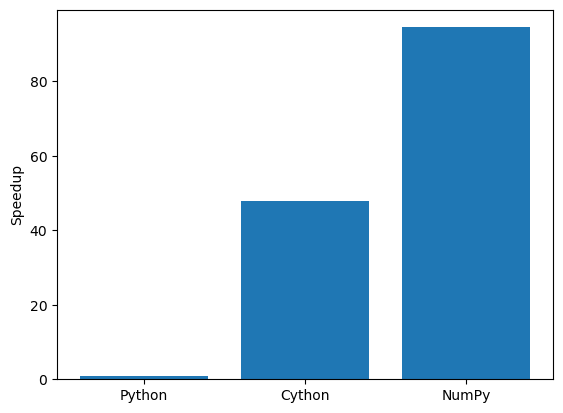

In [49]:
speedups = python_speed.average / np.array([python_speed.average, cython_speed.average, numpy_speed.average])
plt.bar(["Python", "Cython", "NumPy"], speedups)
plt.ylabel("Speedup");

So, in this simple case, on my machine, we didn't beat NumPy here (this makes sense: NumPy uses AVX512 loop vectorisation, which we would need to take more steps to enable here). This is a useful lesson - just because Cython compiles everything to C doesn't mean it will beat other Python libraries which are *also* written in C, and sometimes much more highly optimised than you would be able to achieve yourself.

That said, this is the absolute best-case for NumPy: a simple mathematical operation on a large contiguous array. In general, with multiple and more complicated NumPy calls, Cython starts to win out.

In any case, we still achieved a speedup of ~50x against Python. This is a huge result, especially for such a simple operation as dividing two numbers. In fact, the true Python performance is *even worse*; Cythonising pure Python code as we did here tends to speed it up by about 2x on average.

# Ok, but *what does it add?*

We saw a lot of new syntax in the previous section, which I didn't really explain. Let's do that now.

Primarily, Cython adds:

 - *static typing* - every function and variable has a defined type at compile time.
 - new types which map to underlying C types.
 - a new *typed memoryview* type
 - the ability to write C functions (with Python semantics if desired) and call them transparently
 - support for defining Python *Extension Types*, which mostly act like Python classes, but can have C methods with subtype polymorphism.
 
We'll cover each of these things in turn... leaving extension types until the end.

## Static typing

Cython is statically typed. This is to be compared with Python, which is *dynamically typed*. Static typing is necessary to achieve the performance benefits Cython offers. So what does this mean in practice?

In the following function, `x` is of type `int`. It is always of type `int`, and cannot take on any other type within that function:

In [50]:
%%cython -c-Wno-unused-function --annotate
cdef double f(int x):
    return x

If `x` is an int, why can I return it as a double? Well, like Python, C can perform [implicit type conversions in certain circumstances](https://www.geeksforgeeks.org/implicit-type-conversion-in-c-with-examples/). `x` always has type `int`, but the function returns the `int` to `double` conversion of the value of `x`. We can see this in another example, which fails to compile:

In [51]:
%%cython
cdef double f(int x):
    print("This line doesn't execute!")
    cdef double x = x
    return x


Error compiling Cython file:
------------------------------------------------------------
...
cdef double f(int x):
    print("This line doesn't execute!")
    cdef double x = x
               ^
------------------------------------------------------------

/home/jamie/.cache/ipython/cython/_cython_magic_2841ae61b3992af4e8b13d175d81e0f8.pyx:3:16: 'x' redeclared 

Error compiling Cython file:
------------------------------------------------------------
...
cdef double f(int x):
             ^
------------------------------------------------------------

/home/jamie/.cache/ipython/cython/_cython_magic_2841ae61b3992af4e8b13d175d81e0f8.pyx:1:14: Previous declaration is here


The `cdef double` syntax is how we declare a new variable with type `double` (this is why the error we get refers to x as *redeclared*).

Static types are checked *at compile time*, which is a step which occurs once before a program can be run. This is why the `print` statement does not produce any output. For comparison, let's see a Python `TypeError`, which is produced at *runtime*:

In [52]:
def f(x):
    print("This line executes!")
    return int(x)
f([1, 2, 3])

This line executes!


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

Another way we can break things with static typing is to attempt to implicitly convert a value to an incompatible type. So long as neither type is `object`, this should always error at compile time:

In [53]:
%%cython
cdef double* f(int x):
    return x


Error compiling Cython file:
------------------------------------------------------------
...
cdef double* f(int x):
    return x
          ^
------------------------------------------------------------

/home/jamie/.cache/ipython/cython/_cython_magic_a1fe5cae5b4c078da366f4ab3d34880e.pyx:2:11: Cannot assign type 'int' to 'double *'


Some people just want to see the world burn.

Every variable in Cython has an underlying static type. You may quickly, ahem, object: "what about Python objects?" Python objects are dynamically typed, and I already said Python code is valid Cython. Well, the trick is to treat all `object`s (`PyObject*`s, in C) as [one type](https://existentialtype.wordpress.com/2011/03/19/dynamic-languages-are-static-languages/). For consistency, this type is called `object`, and it is the type of anything not otherwise declared to have a type. This trick allows us to pretend Cython's static typing is optional when, in fact, everything still has a static type, which may be `object`.

As mentioned, C has implicit conversions; in order to smooth development, Cython introduces many of its [own conversions](https://cython.readthedocs.io/en/latest/src/userguide/language_basics.html#automatic-type-conversions) between `object` and the newly introduced C types.

In that context, what happens if we leave off the return type for our function?

In [59]:
%%cython -c-Wno-unused-function --annotate
cdef f(int x):
    return x

As we can see, the return type is now `object`, which means that our `x` value of type `int` must to be converted to a `PyObject*` *containing* an int. Cython is smart enough to insert this conversion for us, in the form of `__Pyx_PyInt_From_int`, and handle the necessary reference counting and error handling.

**Gotcha**: this is one reason that it is important to always check the annotations produced by Cython: implict conversions to and from `object` can happen in unexpected places, trashing the performance of your othterwise optimised code.

## New Types

### Ported C types

All the major players from C are represented:

 | Description           | Type name                                   |
 |:--------------------- |:------------------------------------------- |
 | Signed integer | `signed char` `short`, `int`, `long`, `long long`  |
 | Unsigned integer | `unsigned char`, `unsigned short`, `unsigned int`, `unsigned long`, `unsigned long long`, `size_t` |
 | Character type | `char` | 
 | Floating precision | `float`, `double`.

Generally, use `int` and `unsigned int` (`unsigned` for short) for integer types unless you have a reason. One reason is to store a valid pointer address or array index, in which case use `size_t`. The signedness of `char` is implementation defined, so if you want to use `char` to represent a byte, you should specify the sign you want.
C arrays work as expected, but as expected have many caveats, so avoid them unless you know what you're doing.

There is also a `bint` type, which is backed by a C `int`, but signifies a Boolean.

For real numbers, use `double` in most circumstances. `float` and `double` operations are equally fast, and `double` is more precise. The only times this isn't true are when

 - data transfer has significant overhead (`double` is twice as big as `float` in memory);
 - autovectorisation may come into play, in which case `double` is twice as expensive as `float`. For example, in the division example above, the test loop is autovectorised, and so converting `double` to `float` improves performance by 2x.

### Static Python types

Some Python types have been given static equivalents:

 - `object`
 - `list`
 - `dict`
 - `str`
 - `bytes`

These are really the same as the Python type you know and love (they are still Python `object`s!), but specifying their precise static types can sometimes enable more efficient code. For example, in these two examples, specifying the `list` type makes makes the access through the faster `__Pyx_GetItemInt_List` rather than the more generic `__Pyx_GetItemInt`, and gets the list size through `PyList_GET_SIZE` rather than `PyObject_Length`:

In [131]:
%%cython --annotate
def as_object(l not None):
    cdef size_t i
    for i in range(len(l)):
        l[i]


def as_list(list l not None):
    cdef size_t i
    for i in range(len(l)):
        l[i]

(The `not None` qualifier adds a check that `l` is not `None` and raises a `TypeError` otherwise. This allows Cython to elide a few checks and cleans up the generated C code.)

### ctuples

C does not have tuples, but they are extremely useful and idiomatic to Python, particularly for returning multiple values from a function. Cython provides a simple implementation for C functions called ctuples (which are ultimately backed by C structs).

A ctuples look like this: `(int, double, int)`. The form `(T0, T1, ..., TN)` is a valid type so long as `T0`, `T1`, ..., `TN` are C types.

### Typed Memoryviews

There are two major kinds of array used in typical Python code: the builtin `list`, and the NumPy `ndarray`. The problem in Cython is, there is no nice way to use these. `list` is only ever a list of `object`s, which makes them unsuitable for storing the new Cython types we've talked about. `ndarray` can contain underlying C types, but their API requires calling into Python.

Cython has two solutions to this. One is that it is possible to `cimport numpy` and get access to a Cython API for working with `ndarray` objects. However, this is restricted to `ndarray`, and the API has some limitations.

The most general solution Cython provides is *typed memoryviews*. This is, as the name suggests, a *view* on some data. A typed memoryview can be constructed from many Python types, most importantly `ndarray`, and does not copy their underlying data. Let's see how that works:

In [60]:
%%cython
import numpy as np
def memoryview_eg():
    numpy_array = np.arange(10, dtype=np.intc)
    cdef int[:] mv = numpy_array
    mv[4:7] = 6
    print(numpy_array)

In [61]:
memoryview_eg()

[0 1 2 3 6 6 6 7 8 9]


As you can see, the basic memoryview type is `T[:]` where `T` is a C type. We can access the underlying data of the memoryview with index and slice notation, just like lists. Any changes we make will be reflected in the original data, in this case that owned by the `numpy_array`.

#### Safety checks

What happens if there is no underlying data?

In [62]:
%%cython
def uninitialised_memoryview():
    cdef int[:] mv
    mv[4:7] = 6
    print(mv)

In [63]:
uninitialised_memoryview()

UnboundLocalError: local variable 'mv' referenced before assignment

Cython inserts a check for us to make sure we don't shoot ourselves in the foot, and we get an `UnboundLocalError`.

There are two other checks that Cython does by default:

 - bounds checking
 - wraparound
 
Bounds checking produces an `IndexError` if we go beyond the bounds of our array, just like a Python list.
 
Wraparound mimics the Python list indexing semantics for negative indices. That is, `mv[-1] == mv[len(mv)-1]`. This requires a runtime calculation.

All of these checks are friendly to the programmer, but terrible for performance. If you *know* that your function does not use any of these features, or put the onus on your caller to provide valid inputs, then you can turn them off with special decorators:


In [64]:
%%cython
cimport cython

@cython.boundscheck(False)
@cython.initializedcheck(False)
@cython.wraparound(False)
def unsafe_fn():
    ...

**Gotcha**: if one of these things *does* happen, and you turned the checks off.... it's game over. No exception will be raised. Your program will most likely simply crash.

#### Contiguous arrays

By default, memoryviews do not assume that the data they are accessing is *contiguous* (i.e., value $i$ is adjacent to value $i+1$ in memory). This means that indexing still requires some additional computation. We can add this as part of the type, with some slightly strange syntax:

In [65]:
%%cython
def contiguous_memoryview():
    cdef int[::1] mv

We can also assert that the input to our function should be contiguous by making this the parameter type:

In [66]:
%%cython
def contiguous_memoryview(int[::1] mv):
    print("Called successfully")

This will work fine so long as the data we assign to it actually is contiguous... but otherwise, we will get a `TypeError` at runtime:

In [67]:
contiguous_memoryview(np.arange(10, dtype=np.intc))

Called successfully


In [68]:
contiguous_memoryview(np.arange(10, dtype=np.intc)[::2])

ValueError: ndarray is not C-contiguous

#### Multidimensional arrays

Of course, not all NumPy arrays are 1D. Nor are typed memoryviews:

In [69]:
%%cython
import numpy as np
def multidimensional_memoryview():
    numpy_array = np.arange(50, dtype=np.intc).reshape(5, 10)
    cdef int[:,::1] mv = numpy_array
    mv[1:4, :] = 6
    print(numpy_array)

In [70]:
multidimensional_memoryview()

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 6  6  6  6  6  6  6  6  6  6]
 [ 6  6  6  6  6  6  6  6  6  6]
 [ 6  6  6  6  6  6  6  6  6  6]
 [40 41 42 43 44 45 46 47 48 49]]


In this case, the syntax `[:,::1]` indicates that the data should be C-contiguous (row-major). For Fortran-contiguous (column-major), we would use `[::1, :]`.

## cdef and cpdef functions

As we've seen, there is a new syntax for defining functions using `cdef` instead of `def`. What are the differences between these?

First of all, `cdef` functions *cannot be called from Python*.  This allows them to use a more efficient calling convention (that of C), outside of the Python virtual machine, and discard a lot of the book-keeping that Python otherwise does when calling functions. Primarily, then, `cdef` functions have *lower overhead* to call from Cython than `def` functions.

Another problem with `def` functions is that they only accept and return values of `object`. If you have a call-chain of multiple Cythonised functions, all using Cython types, this means that every function call will convert the Cython types back to `object` in order to pass them as parameters to the next function in the chain, only for that function to convert them back to whatever their actual type was meant to be on the other side. This can really add up in tight loops.

By contrast, so long as every function in the call-chain is a `cdef` function, and all parameters have the correct type specifiers, there will be no unnecessary type conversions.

In [89]:
%%cython -c-Wno-unused-function --annotate

def f(int x, int y):
    return (x + y) / 3

def g(double x):
    return f(x * 30, x * 90)

def h():
    return g(100)

cdef double f_(int x, int y):
    return (x + y) / 3

cdef double g_(double x):
    return f_(<int>x * 30, <int>x * 90)

cdef double h_():
    return g_(100)

**Gotcha**: if we don't add static types, then the default behaviour is to take and return `object`s, so we're almost back where we started (though we still gain from not using Python function calls):

In [90]:
%%cython -c-Wno-unused-function --annotate

cdef f_(x, y):
    return (x + y) / 3

cdef g_(x):
    return f_(<int>x * 30, <int>x * 90)

cdef h_():
    return g_(100)

Finally, you may be able to imagine a situation in which you want a function to be called from C where possible, but otherwise is still accessible from Python. We could easily write a wrapper function to do this... but happily, Cython can do this for us with `cpdef`:

In [91]:
%%cython -c-Wno-unused-function --annotate

cpdef double f_(int x, int y):
    return (x + y) / 3

cpdef double g_(double x):
    return f_(<int>x * 30, <int>x * 90)

cpdef double h_():
    return g_(100)

In [92]:
h_()

4000.0

The yellow on each `cpdef` line looks scary, but in fact it's almost equivalently fast to call from Cython as a `cdef` function.

# Worked Example

Now let's go through some example Python code, optimising it step by step, until we arrive at some nice optimised Cython.

We'll pick an example where NumPy won't win, purely out of spite. How about... computing the first $N$ Fibonacci numbers? But, because this explodes, let's also subtract $a_{i-3}$ from $a_i$, so we can test against large $N$.

## Version 0

In [71]:
%%cython --annotate
import numpy as np

def n_fibs_0(n):
    array = np.empty(max(3, n), dtype=int)
    array[:3] = [1, 1, 2]
    for i in range(n - 3):
        array[i+3] = array[i+2] + array[i+1] - array[i] 
    return array[:n]

In [72]:
n_fibs_0(0), n_fibs_0(1), n_fibs_0(2), n_fibs_0(3), n_fibs_0(4)

(array([], dtype=int64),
 array([1]),
 array([1, 1]),
 array([1, 1, 2]),
 array([1, 1, 2, 2]))

## Version 1: adding types

First of all, let's add some types to the proceedings:

In [73]:
%%cython --annotate
import numpy as np

def n_fibs_1(int n):
    array = np.empty(max(3, n), dtype=int)
    array[:3] = [1, 1, 2]
    for i in range(n - 3):
        array[i+3] = array[i+2] + array[i+1] - array[i]
    return array[:n]

Hmm. Even though `n` is now a C `int`, it's actually made things worse! 

Because this is a `def` function and not `cdef`, this function can be called from Python. That means that Cython does not know the *real* type of `n`. To be clear, in Python, I can still call `n_fibs_1` with whatever I like at runtime:

In [74]:
n_fibs_1("this is not an int")

TypeError: an integer is required

In order to make this work, Cython has implicitly added a type check to the beginning of the function before unwrapping the `int` value (if there is one). When dealing with `def` functions, all of the parameters *come in* as `object` type; any static type specifiers on the arguments will be implicitly checked and converted at runtime. This is **not** the case for `cdef` functions, where the input parameter types *are* known at compile time.

It gets worse. We've converted `n` to type `int`, but none of the places that `n` is used currently expect an `int`. They are all calls to Python functions, which can only accept `object` parameters: `np.empty(n, ...)` and `range(n - 3)`.
This means that `n` must be converted back to `object` in the two places it is used, making the `int` conversion redundant.

Both of these uses are outside of the loop body, so they don't necessarily impact performance, but they illustrate the pitfall of converting everything to Cython types "for speed".

## Version 2: typed range

In fact, `range` *does* take an integer value so long as the loop variable (in this case `i`) is itself an integer, and the result will perform better:

In [75]:
%%cython --annotate
import numpy as np

def n_fibs_2(int n):
    array = np.empty(max(3, n), dtype=int)
    array[:3] = [1, 1, 2]
    
    cdef size_t i
    for i in range(n - 3):
        array[i+3] = array[i+2] + array[i+1] - array[i]
    return array[:n]

In fact, the `int n` here is arguably pointless, but we'll leave it in for now so we can see more yellow disappear.

## Version 3: typed memoryviews

The next problem is that `array` is of type `object`. We can do better... with a typed memoryview!

In [76]:
%%cython --annotate
import numpy as np

def n_fibs_3(int n):
    array = np.empty(max(3, n), dtype=np.intc)
    array[:3] = [1, 1, 2]
    
    cdef:
        int[::1] mv = array
        size_t i
    for i in range(n - 3):
        mv[i+3] = mv[i+2] + mv[i+1] - mv[i]
    return array[:n]

You may be wondering: "we set the values in the `mv` variable - why are we returning `array`?"

Remember that a memoryview is a *view* on some data. It does not (usually) *own* that data. We can pass around memoryviews and rely on them keeping their underlying data alive, but we can also keep the original owner of the data (in this case, `array`) around. The memoryview API is fairly limited, while the NumPy array API is extremely rich. Memoryviews can be used as a *lens* into the richer structure to access or modify it in an efficient, type-aware way. Once we're done, we can throw the lens away and return the rich object. This also maintains our API when performing Cython optimisations - other people's code which calls `n_fibs` won't suddenly break because we started returning a `memoryview` and not an `ndarray`.

As an aside, if you ever want to convert a memoryview into a numpy array, you can use `np.asarray(mv)` without performing any copies of the underlying data.

Note that on line 4 we had to change the `dtype` of the NumPy array to `intc`. This ensures that the NumPy array is backed by integers of the same size as C `int` values (on my machine, 4 bytes) and not some other size. If we don't do this, we (may!) get an error at runtime (on some platforms!).

## Version 4: no bounds checking

Ok, ok. So, we've converted the array, but line 11 is still yellow... when we unfold it, we see a lot of `__Pyx_RaiseBufferIndexError` messages. We need to turn off bounds checking!

In [77]:
%%cython --annotate
cimport cython
import numpy as np

@cython.boundscheck(False)
def n_fibs_4(int n):
    array = np.empty(max(3, n), dtype=np.intc)
    array[:3] = [1, 1, 2]
    
    cdef:
        int[::1] mv = array
        size_t i
    for i in range(n - 3):
        mv[i+3] = mv[i+2] + mv[i+1] - mv[i]
    return array[:n]

With this, there's probably not much more we can eke out of this tiny little function. Of course, if we were calling it in a hot loop, we may want to remove the use of numpy arrays at all, but that goes beyond the scope of this note.

## Performance

So, how did we do? Let's measure.

In [78]:
fibs0 = %timeit -o n_fibs_0(1_000_000)

196 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
fibs1 = %timeit -o n_fibs_1(1_000_000)

202 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
fibs2 = %timeit -o n_fibs_2(1_000_000)

115 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
fibs3 = %timeit -o n_fibs_3(1_000_000)

1.07 ms ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [82]:
fibs4 = %timeit -o n_fibs_4(1_000_000)

434 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


times = {f"fibs{n}": globals()[f"fibs{n}"].average for n in range(5)}
speedups = {k:times["fibs0"]/v for k, v in times.items()}
plt.bar(speedups.keys(), speedups.values(), log=True)
plt.ylabel("Speedup");

I think we can be happy with that - an almost 140x speedup on my machine!

# Extension Types

Python is commonly used in an object oriented way. In a large Cython code-base, you may want to provide a class which has optimised methods when called from Cython. However, if you naively attempted to add a `cdef` method to a Python class, you would run into trouble:

In [97]:
%%cython
class MyPythonClass:
    cdef my_optimised_method(self):
        ...


Error compiling Cython file:
------------------------------------------------------------
...
class MyPythonClass:
    cdef my_optimised_method(self):
        ^
------------------------------------------------------------

/home/jamie/.cache/ipython/cython/_cython_magic_1f4f369cb312905bb9104e84d1fbd76c.pyx:2:9: cdef statement not allowed here


Uh-oh! Due to the semantics of Python classes, this doesn't work. We need a different approach.

Luckily, Cython provides exactly what we're looking for in the form of *extension types*:

In [99]:
%%cython
cdef class MyExtensionType:
    cdef my_optimised_method(self):
        ...

Extension types are a Python feature which allow hooking custom behaviour to Python objects. Cython simply exposes its own variety of extension types through the language as `cdef class`. So how do Cython extension types compare to Python classes?

First, let's see a more fleshed out example:

In [138]:
%%cython
cdef class Car:
    cdef int num_wheels
    cdef readonly str registration
    cdef public unsigned num_passengers
    
    def __init__(self):
        self.num_wheels = 4
        self.registration = "MONTY"
        self.num_passengers = 0
    
    cdef go_fast(self):
        print(f"Going fast with {self.num_wheels} wheels.")

    def go_slow(self):
        print(f"Going fast with {self.num_wheels} wheels.")
        
    cpdef go_fast_or_slow(self):
        print(f"Travelling with {self.num_wheels} wheels.") 

In this definition, we've set up a few *attributes* on the class. Unlike normal Python classes, these are statically typed, and they go in the *class definition*. Only the defined attributes are valid; trying to set an attribute on an extension class which isn't defined is raises an `AttributeError`.

The attributes have different *access specifiers*: `private` (the default), `readonly`, and `public`. This refers to the allowed access *from Python*. Cython code can still access and change all of these attributes indiscriminately.

We then have an `__init__` method much as normal. Then we define our methods, which are `cdef`, `def` and `cpdef`. Note that all the methods can still access the private attribute `num_wheels`; this is because all of these are compiled with Cython, even if they are accessible from Python and behave as Python functions (in the case of `go_slow` and `go_fast_or_slow`).

We can make one of these from Python, just like a normal Python class:

In [139]:
my_car = Car()

But, from Python, we can't access all of its attributes:

In [140]:
[a for a in dir(my_car) if not a.startswith("__")]

['go_fast_or_slow', 'go_slow', 'num_passengers', 'registration']

We can access its *public* and *readonly* attributes:

In [141]:
my_car.registration, my_car.num_passengers

('MONTY', 0)

We can set its *public* attributes:

In [142]:
my_car.num_passengers = 1
my_car.num_passengers

1

But we *can't* access its private attributes:

In [143]:
my_car.num_wheels

AttributeError: '_cython_magic_51a378393b7ba3c545ba8248dcae7373.Car' object has no attribute 'num_wheels'

Nor can we set its *readonly* attributes:

In [144]:
my_car.registration = "PYTHON"

AttributeError: attribute 'registration' of '_cython_magic_51a378393b7ba3c545ba8248dcae7373.Car' objects is not writable

We can call its `def` and `cpdef` methods:

In [146]:
my_car.go_slow()
my_car.go_fast_or_slow()

Going fast with 4 wheels.
Travelling with 4 wheels.


But not `cdef` methods:

In [147]:
my_car.go_fast()

AttributeError: '_cython_magic_51a378393b7ba3c545ba8248dcae7373.Car' object has no attribute 'go_fast'

## Static typing

As we've seen, extension types act much like normal Python classes.  They are of type `object`, so we can pass them around to Python functions and methods as usual. However, to access their special attributes and methods from Cython, and not incur the normal runtime calculations, we need to know that we're dealing with an extension type at compile time. In order to do this, we can use extension type names as type specifiers, much like `list` and `str`:

In [157]:
%%cython -c-Wno-unused-function --annotate
cdef class A:
    cdef int x
    cpdef f(self):
        ...
    
def f(obj):
    obj.f()
    obj.x
    cdef A a = obj
    a.f()
    a.x

## Subclassing

We can inherit from extension types, and things *mostly* work as expected. For example:

In [165]:
%%cython
cdef class A():
    def f(self):
        self.g()
    
    cdef g(self):
        print("Calling A.g()")
    
cdef class B(A):
    cdef g(self):
        print("Calling B.g()")
        
def polymorphism():
    cdef A a = A()
    cdef B b = B()
    
    a.f()
    b.f()
    
    cdef A b_as_a = B()
    b_as_a.f()

In [166]:
polymorphism()

Calling A.g()
Calling B.g()
Calling B.g()


Both extension types and normal Python classes can inherit from an extension type, but extension types cannot inherit from a normal Python class:

In [100]:
%%cython

cdef class EA:
    ...
    
cdef class EB(EA):
    ...
    
class C(EA):
    ...

In [102]:
%%cython

class A:
    ...
    
class B(A):
    ...
    
cdef class EC(A):
    ...


Error compiling Cython file:
------------------------------------------------------------
...
    ...
    
class B(A):
    ...
    
cdef class EC(A):
             ^
------------------------------------------------------------

/home/jamie/.cache/ipython/cython/_cython_magic_184fe11d94979ad7412446e56973331e.pyx:8:14: First base of 'EC' is not an extension type
